<a href="https://colab.research.google.com/github/Tapish0305/Medical_Imaging/blob/main/medical_imaging_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING DEPENDENCIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torch
import shutil ## copying , deleting file
import os
import matplotlib.colors as mcolors
import seaborn as sns
import yaml
import cv2

from tqdm.notebook import tqdm
from glob import glob ## used to search files which start with some specific pattern
from PIL import Image
from collections import Counter
from os import listdir
from os.path import isfile, join
from IPython.display import Image, clear_output
from sklearn.model_selection import GroupKFold
import kagglehub
import warnings
import random
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.4
    Uninstalling albumentations-2.0.4:
      Successfully uninstalled albumentations-2.0.4


In [ ]:
import albumentations as A

## DATA LOADING

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/vinbigdata-512-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vinbigdata-512-image-dataset


In [ ]:
vinbigdata_yolo_labels_dataset_path = kagglehub.dataset_download('awsaf49/vinbigdata-yolo-labels-dataset')

In [ ]:
dim = 512

## DATA DESCRIPTION

In [ ]:
train_df = pd.read_csv('/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train.csv')

In [ ]:
train_df.shape

(67914, 10)

In [ ]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  width  height  
0     NaN     NaN     NaN     NaN   2332    2580  
1     NaN     NaN     NaN     NaN   2954    3159  
2   691.0  1375.0  1653.0  1831.0   2080    2336  
3  1264.0   743.0  1611.0  1019.0   2304    2880  
4     NaN     NaN     NaN     NaN   2540    3072

In [ ]:
index = train_df[train_df["class_name"] == 'No finding'].index

In [ ]:

train_df = train_df.drop(index)
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df.shape

(36096, 10)

In [ ]:
dim = 512

In [ ]:
train_df['file_path'] = f'/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if dim!='original' else '.jpg')
train_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

    x_min   y_min   x_max   y_max  width  height  \
0   691.0  1375.0  1653.0  1831.0   2080    2336   
1  1264.0   743.0  1611.0  1019.0   2304    2880   
2   627.0   357.0   947.0   433.0   2540    3072   
3  1347.0   245.0  2188.0  2169.0   2285    2555   
4   557.0  2352.0   675.0  2484.0   2568    3353   

                                           file_path  
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  
4  /kaggle/input/vinbigdata-512-image-dataset/vin...

In [ ]:
(train_df.class_id == 'NaN').sum()

0

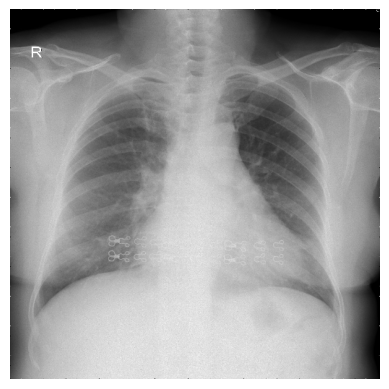

In [ ]:
image_path = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png'
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(image_rgb)
plt.axis("off")
plt.imshow(image)

In [ ]:
train_df.columns

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max', 'width', 'height', 'file_path'],
      dtype='object')

In [ ]:
image.shape

(512, 512, 3)

In [ ]:
train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)

train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max + row.x_min)/2 , axis=1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max + row.y_min)/2 , axis=1)

In [ ]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

      x_min     y_min     x_max     y_max  width  height  \
0  0.332212  0.588613  0.794712  0.783818   2080    2336   
1  0.548611  0.257986  0.699219  0.353819   2304    2880   
2  0.246850  0.116211  0.372835  0.140951   2540    3072   
3  0.589497  0.095890  0.957549  0.848924   2285    2555   
4  0.216900  0.701461  0.262850  0.740829   2568    3353   

                                           file_path     x_mid     y_mid  
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.563462  0.686216  
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.623915  0.305903  
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.309843  0.128581  
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.773523  0.472407  
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.239875  0.721145

In [ ]:
(train_df.class_id == '14').sum()

0

## EXPLORATORY DATA ANALYSIS

In [ ]:
class_name = train_df[['class_name']].value_counts()
list_label = class_name
list_label

class_name        
Aortic enlargement    7162
Cardiomegaly          5427
Pleural thickening    4842
Pulmonary fibrosis    4655
Nodule/Mass           2580
Lung Opacity          2483
Pleural effusion      2476
Other lesion          2203
Infiltration          1247
ILD                   1000
Calcification          960
Consolidation          556
Atelectasis            279
Pneumothorax           226
Name: count, dtype: int64

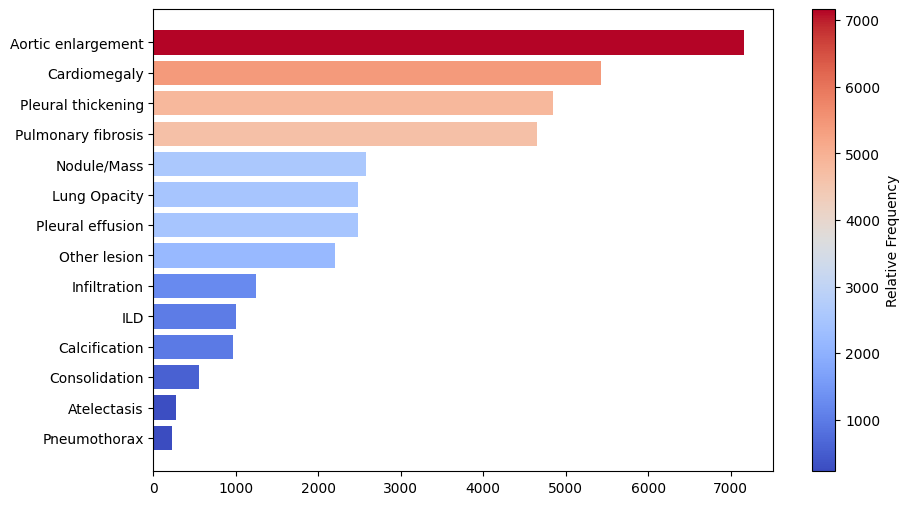

In [ ]:
# Data
series = pd.Series({
    "Aortic enlargement": 7162,
    "Cardiomegaly": 5427,
    "Pleural thickening": 4842,
    "Pulmonary fibrosis": 4655,
    "Nodule/Mass": 2580,
    "Lung Opacity": 2483,
    "Pleural effusion": 2476,
    "Other lesion": 2203,
    "Infiltration": 1247,
    "ILD": 1000,
    "Calcification": 960,
    "Consolidation": 556,
    "Atelectasis": 279,
    "Pneumothorax": 226,
})

df = series.reset_index()
df.columns = ['class_name', 'count']
list_class_name = df['class_name'].tolist()
list_count = df['count'].tolist()

# Normalize for color mapping
## Map numerical values to colour neutral to warm red
normalize = (df['count'] - min(df['count'])) / (max(df['count']) - min(df['count']))
cmap = plt.cm.coolwarm
colors = cmap(normalize)

# Create plot
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(list_class_name, list_count, color=colors)
ax.invert_yaxis()  # Reverse y-axis for better visualization

# Create a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(list_count), vmax=max(list_count)))
sm.set_array([])  # Necessary to avoid error


cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Relative Frequency')

plt.show()


## Data Augumentation

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.2),
    A.Rotate(limit = 90, p = 0.2),
    A.RandomBrightnessContrast(p = 0.2),
    A.GaussNoise(var_limit = (10,40), p = 0.2),
    A.GaussianBlur(blur_limit = (3, 7), p = 0.2)]
)

In [ ]:
list_class_name

['Aortic enlargement',
 'Cardiomegaly',
 'Pleural thickening',
 'Pulmonary fibrosis',
 'Nodule/Mass',
 'Lung Opacity',
 'Pleural effusion',
 'Other lesion',
 'Infiltration',
 'ILD',
 'Calcification',
 'Consolidation',
 'Atelectasis',
 'Pneumothorax']

# YOLO v8 ARCHITECT

In [ ]:
gkf = GroupKFold(n_splits = 5)
train_df['fold'] = -1
cou = 0
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
    print(len(train_idx)," ",len(val_idx))

28876   7220
28876   7220
28876   7220
28879   7217
28877   7219


In [ ]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

      x_min     y_min     x_max     y_max  width  height  \
0  0.332212  0.588613  0.794712  0.783818   2080    2336   
1  0.548611  0.257986  0.699219  0.353819   2304    2880   
2  0.246850  0.116211  0.372835  0.140951   2540    3072   
3  0.589497  0.095890  0.957549  0.848924   2285    2555   
4  0.216900  0.701461  0.262850  0.740829   2568    3353   

                                           file_path     x_mid     y_mid  fold  
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.563462  0.686216     3  
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.623915  0.305903     4  
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.309843  0.128581     1  
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.773523  0.472407     4  
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.239875  0.721145     3

In [ ]:
train_df.shape

(36096, 14)

In [ ]:
fold

4

In [ ]:
train_files = []
val_files = []
val_files += list(train_df[train_df['fold']==fold].file_path.unique())
train_files += list(train_df[train_df['fold']!=fold].file_path.unique())
train_files[0]

'/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png'

In [ ]:
train_df['w'] = (train_df['x_min']+train_df['x_max'])/2
train_df['h'] = (train_df['y_min']+train_df['y_max'])/2
train_df = train_df[['class_id', 'x_mid', 'y_mid', 'w', 'h']]
train_df

class_id     x_mid     y_mid         w         h
0             3  0.563462  0.686216  0.563462  0.686216
1             0  0.623915  0.305903  0.623915  0.305903
2            11  0.309843  0.128581  0.309843  0.128581
3             5  0.773523  0.472407  0.773523  0.472407
4             8  0.239875  0.721145  0.239875  0.721145
...         ...       ...       ...       ...       ...
36091        10  0.174045  0.616493  0.174045  0.616493
36092        13  0.407064  0.281250  0.407064  0.281250
36093         5  0.266846  0.434400  0.266846  0.434400
36094         9  0.060330  0.417708  0.060330  0.417708
36095         3  0.622713  0.561275  0.622713  0.561275

[36096 rows x 5 columns]

## IMAGES

In [ ]:
os.makedirs('/kaggle/working/config/images/train/', exist_ok = True)
os.makedirs('/kaggle/working/config/images/val/', exist_ok = True)
os.makedirs('/kaggle/working/config/labels/train/', exist_ok = True)
os.makedirs('/kaggle/working/config/labels/val/', exist_ok = True)

In [ ]:
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels/'

for file in train_files:
    shutil.copy(file,'/kaggle/working/config/images/train/')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename + '.txt'), '/kaggle/working/config/labels/train/')

for file in val_files:
    shutil.copy(file, '/kaggle/working/config/images/val/')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir,filename+'.txt'), '/kaggle/working/config/labels/val/')

In [ ]:
cwd = '/kaggle/working/'

with open(join(cwd, 'train.txt'),'w') as f:
    for file in glob('/kaggle/working/config/images/train/*'):
        f.write(file+'\n')

with open(join(cwd, 'val.txt'),'w') as f:
    for file in glob('/kaggle/working/config/images/val/*'):
        f.write(file+'\n')

In [ ]:
data = dict(
    train =  join(cwd, 'train.txt'),
    val   =  join(cwd, 'val.txt'),
    nc    = 14,
    names = list_class_name
    )

with open(join('/kaggle/working/', 'config.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join('/kaggle/working/' , 'config.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Cardiomegaly
- Pleural thickening
- Pulmonary fibrosis
- Nodule/Mass
- Lung Opacity
- Pleural effusion
- Other lesion
- Infiltration
- ILD
- Calcification
- Consolidation
- Atelectasis
- Pneumothorax
nc: 14
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [ ]:
from ultralytics import YOL

model = YOLO("yolov8x.pt")


model.train(
    data="/kaggle/working/config.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device=[0, 1],
    project="/kaggle/working/custom_runs",  # custom folder
    name="exp1"  # experiment name
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPUs available: 2


100%|██████████| 131M/131M [00:00<00:00, 299MB/s] 


Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/config.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ov

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 67.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2659.4±670.9 MB/s, size: 140.9 KB)


train: Scanning /kaggle/working/config/labels/train... 3515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3515/3515 [00:05<00:00, 686.45it/s]


train: New cache created: /kaggle/working/config/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 1495.0±889.1 MB/s, size: 136.3 KB)


val: Scanning /kaggle/working/config/labels/val... 879 images, 0 backgrounds, 0 corrupt: 100%|██████████| 879/879 [00:00<00:00, 900.46it/s] 


val: New cache created: /kaggle/working/config/labels/val.cache
Plotting labels to /kaggle/working/custom_runs/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/custom_runs/exp1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.77G      1.927      2.835      1.912         47        640: 100%|██████████| 220/220 [02:29<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


                   all        879       7219      0.293      0.156      0.111     0.0563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       7.1G      1.771      2.319      1.805         64        640: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


                   all        879       7219      0.265      0.195      0.144     0.0699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.33G      1.764      2.268      1.819         98        640: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.365      0.205      0.143     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.33G      1.722      2.162      1.765         65        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


                   all        879       7219      0.412      0.221      0.172     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.39G      1.693      2.083      1.717         72        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


                   all        879       7219      0.325      0.207      0.154     0.0724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.38G      1.675      2.055       1.72         94        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.332      0.206      0.199     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.38G      1.643       1.98      1.685         97        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.284      0.245      0.216      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.38G      1.623      1.973       1.69         48        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


                   all        879       7219      0.327      0.279      0.221      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.37G        1.6      1.912      1.663         73        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


                   all        879       7219      0.285      0.241      0.212      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.37G      1.595      1.909      1.661         80        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


                   all        879       7219      0.383      0.297      0.252      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.36G      1.565      1.818      1.613         75        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219       0.34      0.291      0.248       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.37G      1.592      1.865       1.64         58        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


                   all        879       7219      0.364      0.275      0.233      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.37G      1.561      1.828       1.63         50        640: 100%|██████████| 220/220 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


                   all        879       7219      0.306      0.315      0.242      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.34G      1.544      1.779      1.595         95        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


                   all        879       7219      0.385      0.305      0.281      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.38G      1.534       1.77      1.615         73        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.352      0.319      0.259      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.35G      1.524       1.75      1.602         60        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


                   all        879       7219      0.361      0.323      0.285      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.36G      1.514      1.722       1.58         42        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.382        0.3       0.28      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.39G      1.502      1.714      1.572         56        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.364      0.317      0.281      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.36G        1.5      1.684      1.572        107        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.367      0.329      0.291      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.37G      1.472      1.639       1.54         68        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.389      0.328        0.3      0.149
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.37G      1.502      1.633       1.65         37        640: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.382      0.324      0.309      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.35G      1.487      1.606      1.652         38        640: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


                   all        879       7219      0.401       0.32      0.302      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.39G       1.47      1.563      1.628         49        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.404      0.341      0.322       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.37G      1.464      1.551      1.614         43        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.382      0.346      0.312      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.35G      1.454      1.519      1.607         70        640: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.397      0.347      0.325      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.39G      1.434      1.495      1.607         35        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.403      0.342      0.321      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.36G      1.411      1.458      1.574         42        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.393       0.35      0.321      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.38G      1.402      1.441      1.584         45        640: 100%|██████████| 220/220 [02:46<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


                   all        879       7219      0.407      0.369      0.336      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.37G      1.388      1.415      1.554         34        640: 100%|██████████| 220/220 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


                   all        879       7219      0.404      0.362      0.332      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.39G      1.372      1.402      1.551         33        640: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


                   all        879       7219      0.394       0.36      0.325      0.163

30 epochs completed in 1.671 hours.
Optimizer stripped from /kaggle/working/custom_runs/exp1/weights/last.pt, 136.7MB
Optimizer stripped from /kaggle/working/custom_runs/exp1/weights/best.pt, 136.7MB

Validating /kaggle/working/custom_runs/exp1/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,137,050 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


                   all        879       7219      0.401      0.365      0.332      0.168
    Aortic enlargement        617       1446      0.701      0.627      0.699      0.433
          Cardiomegaly         40         64      0.381      0.266      0.279     0.0991
    Pleural thickening         95        191      0.319      0.225      0.211     0.0918
    Pulmonary fibrosis        463       1104      0.779      0.544      0.652      0.446
           Nodule/Mass         73        113      0.426      0.372      0.319      0.141
          Lung Opacity         67        187       0.33      0.324      0.298      0.153
      Pleural effusion        110        224      0.408      0.321      0.313      0.149
          Other lesion        272        514       0.35      0.362       0.28      0.112
          Infiltration        163        496       0.45      0.298      0.279       0.15
                   ILD        235        437      0.236      0.144      0.107     0.0411
         Calcificatio

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 32.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/custom_runs/exp1


## LOSSES CURVE

Text(0.5, 1.0, 'Training Metrics (Loss/Accuracy Curves)')

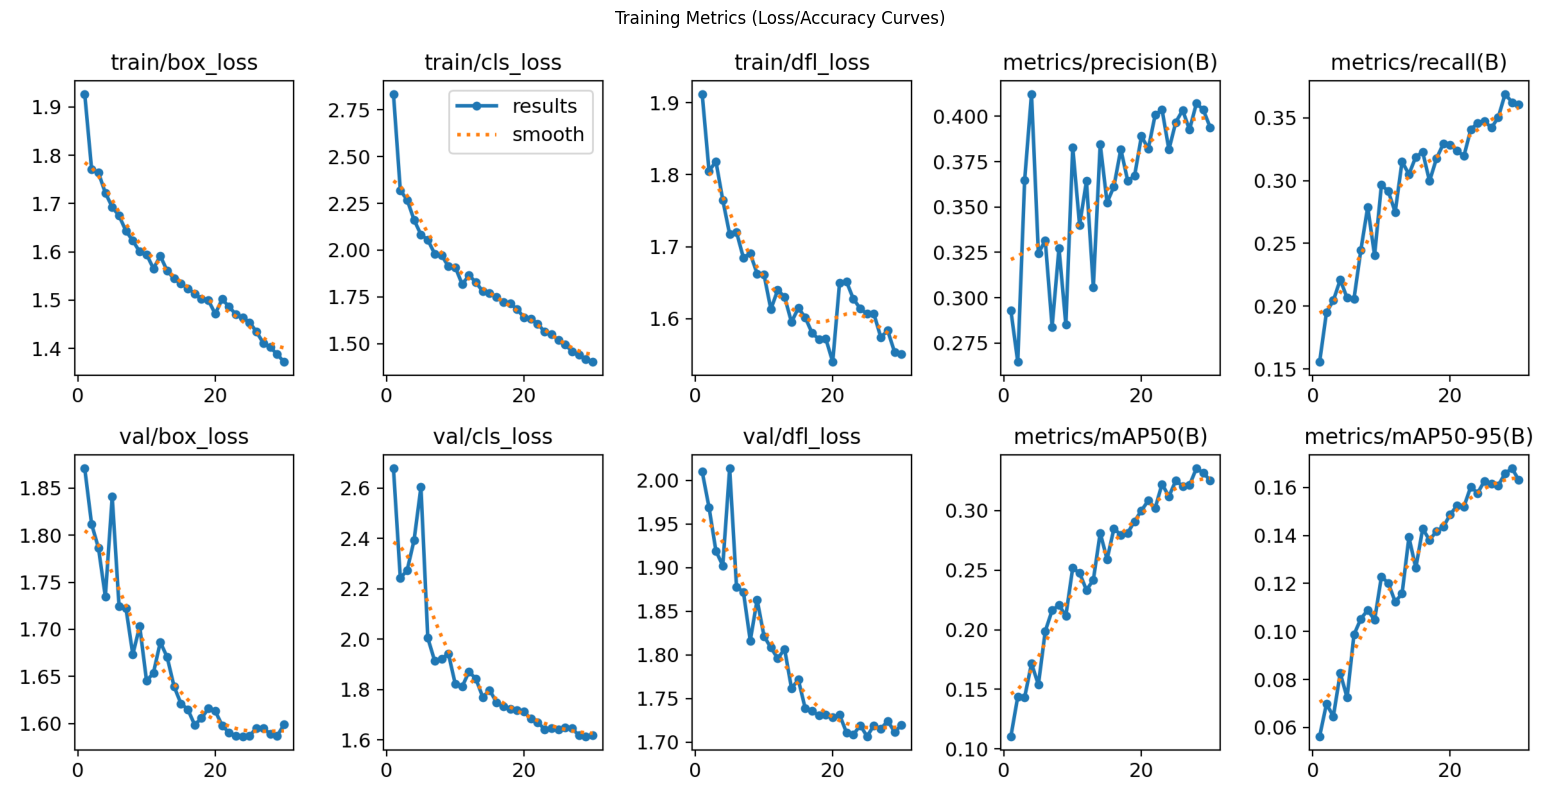

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20, 10))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/results.png'))
plt.axis('off')
plt.title("Training Metrics (Loss/Accuracy Curves)")

## LABEL CURVE

Text(0.5, 1.0, 'LABELS')

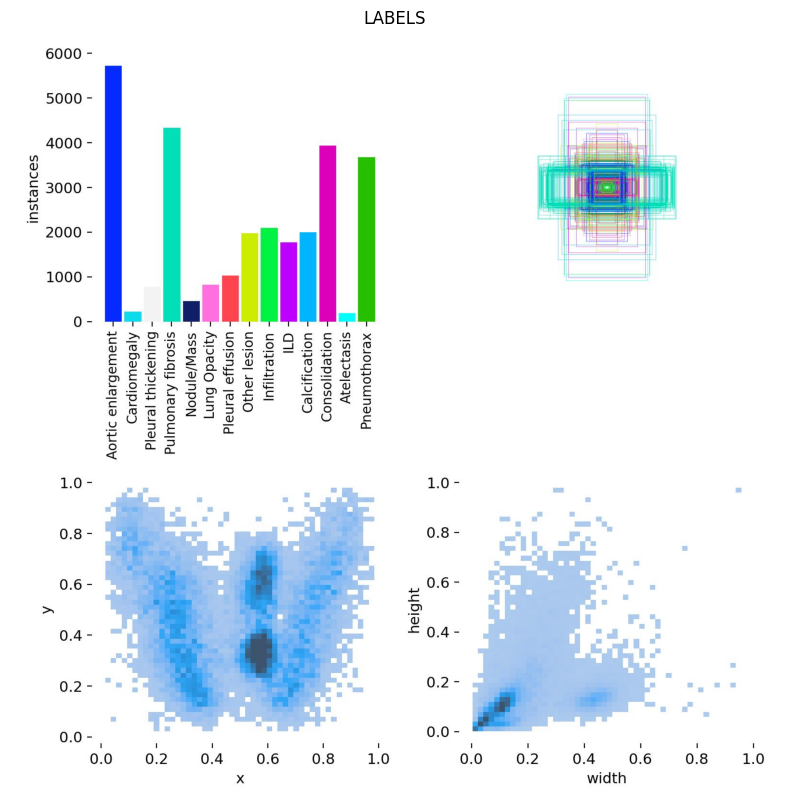

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20, 10))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/labels.jpg'))
plt.axis('off')
plt.title("LABELS")

## CONFUSION MATRIX

Text(0.5, 1.0, 'Training Metrics (Loss/Accuracy Curves)')

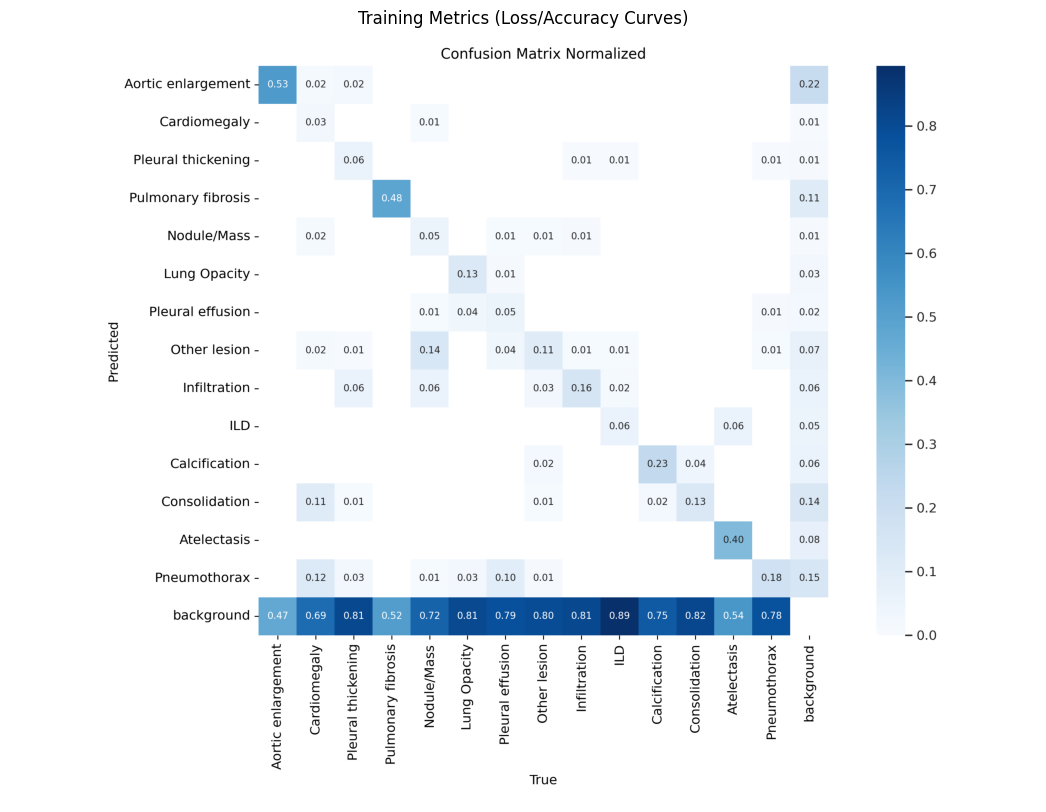

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20, 10))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/confusion_matrix.png'))
plt.axis('off')
plt.title("CONFUSION MATRIX")


## Training batch results

Text(0.5, 1.0, 'Training batch 2 loss')

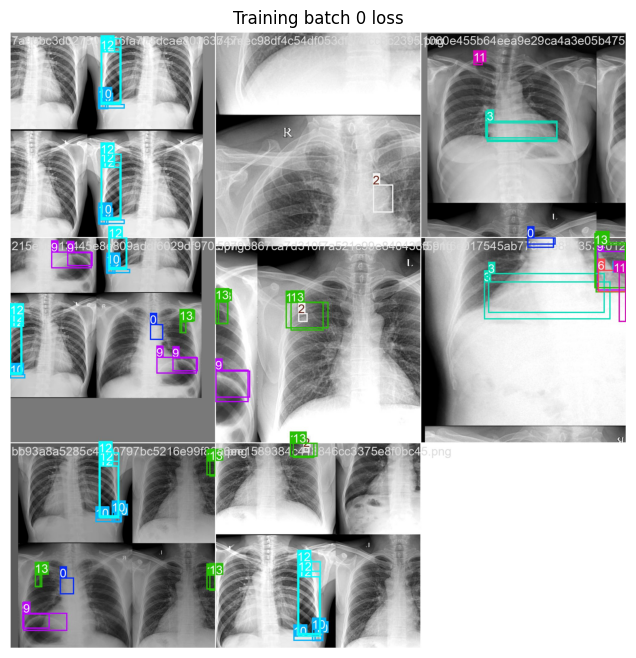

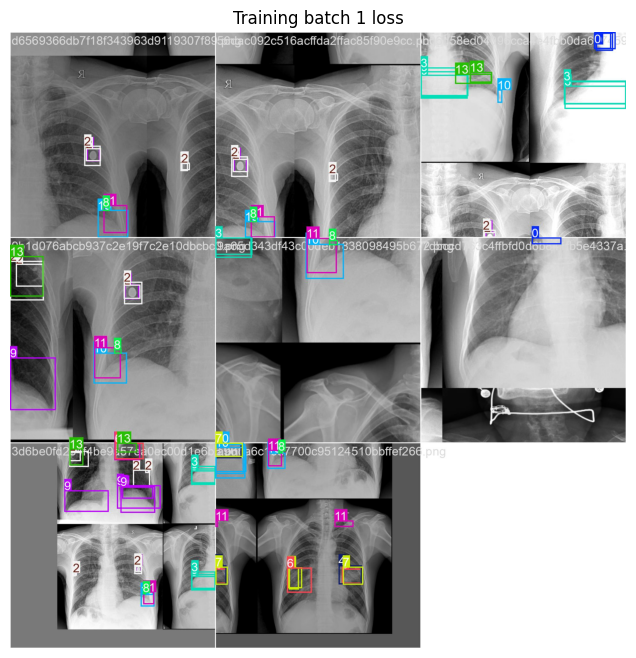

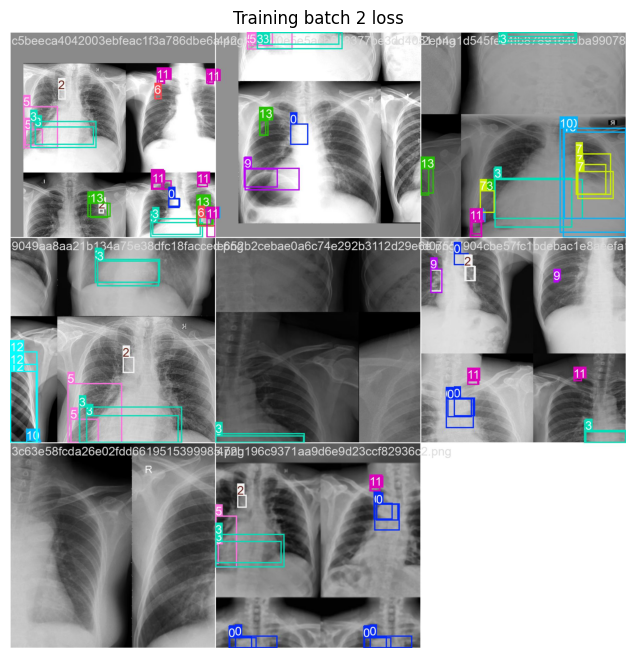

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8,8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/train_batch0.jpg'))
plt.axis('off')
plt.title("Training batch 0")
plt.figure(figsize=(8,8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/train_batch1.jpg'))
plt.axis('off')
plt.title("Training batch 1")
plt.figure(figsize=(8,8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/train_batch2.jpg'))
plt.axis('off')
plt.title("Training batch 2")


## Comparision between validation images and prediction

Text(0.5, 1.0, 'Validation batch 0 preds')

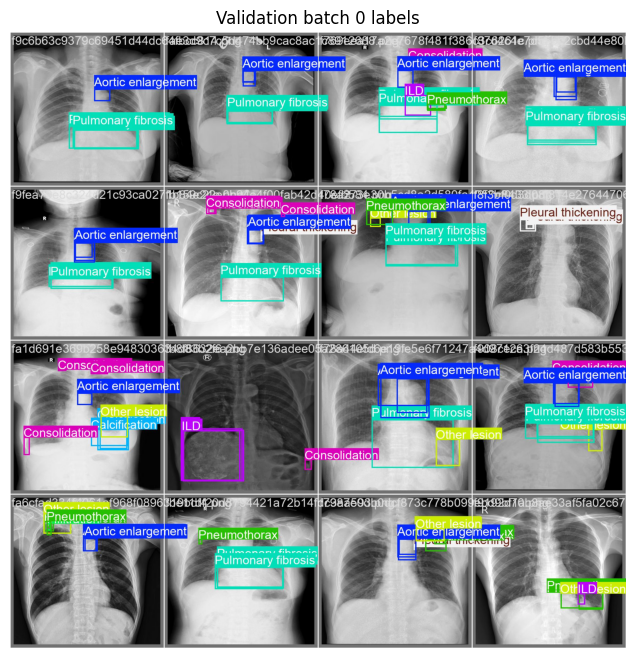

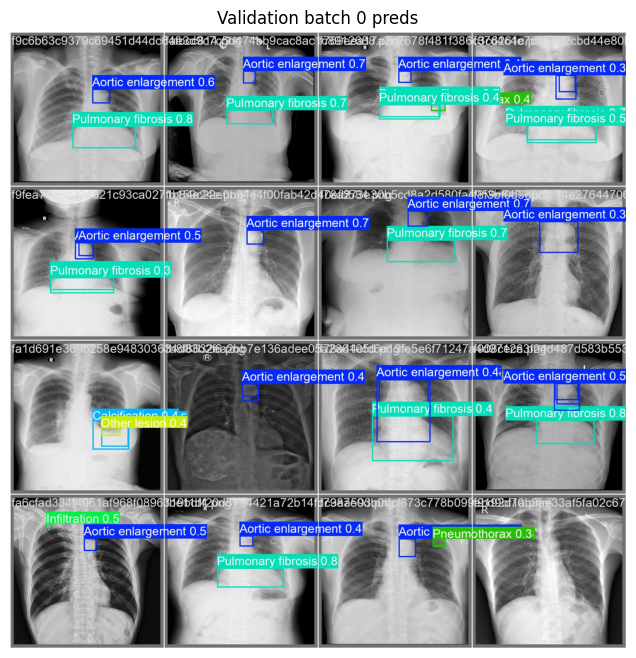

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/val_batch0_labels.jpg'))
plt.axis('off')
plt.title("Validation batch 0 labels")

plt.figure(figsize=(8,8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/val_batch0_pred.jpg'))
plt.axis('off')
plt.title("Validation batch 0 preds")

LABEL CORRELOGRAM

Text(0.5, 1.0, 'LABEL CORRELOGRAM')

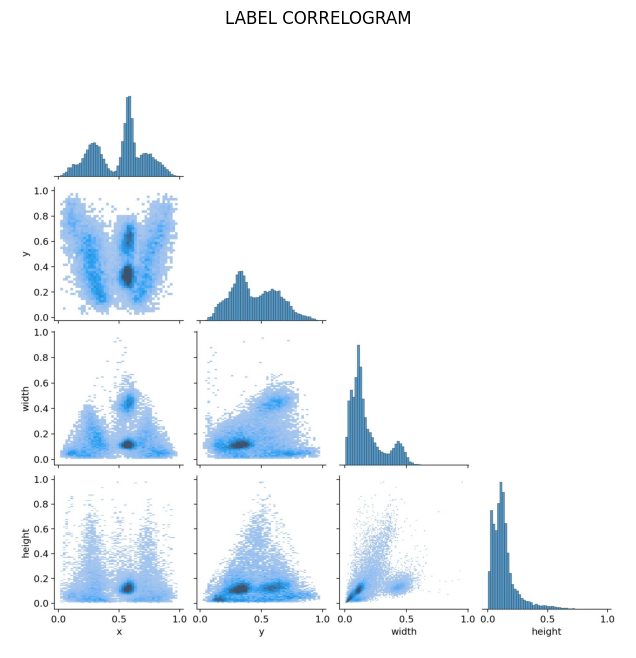

In [ ]:
import matplotlib.image as mpimg
plt.figure(figsize=(8, 8))
plt.imshow(mpimg.imread('/kaggle/working/custom_runs/exp1/labels_correlogram.jpg'))
plt.axis('off')
plt.title("LABEL CORRELOGRAM")

## PREDICTED IMAGE

In [ ]:
from ultralytics import YOLO
model = YOLO('/kaggle/working/custom_runs/exp1/weights/best.pt')
result = model.predict('/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test', save = True, conf = 0.25) ## conf tells use about except result only whenn the confidence> 50


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Consolidation, 75.5ms
image 2/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 1 Aortic enlargement, 62.0ms
image 3/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic enlargement, 1 Pulmonary fibrosis, 60.8m

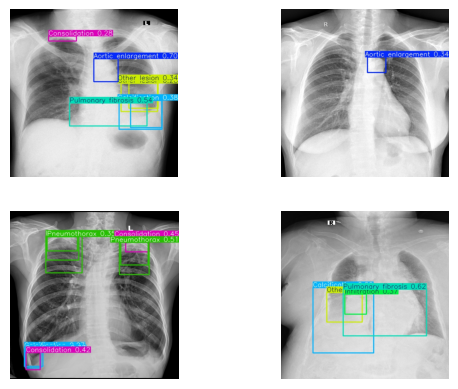

In [ ]:
import matplotlib.image as mpimg
path = '/kaggle/working/runs/detect/predict2'
all_files = os.listdir(path)
pred_images = [f for f in all_files]
pred_imag = random.sample(pred_images, 4)
for i,f in enumerate(pred_imag):
    lists = os.path.join(path, f)
    plt.subplot(2,2,i+1)
    plt.imshow(mpimg.imread(lists))
    plt.axis('off')